In [1]:
import torch
import joblib
import pickle
import pandas as pd
import numpy as np
from functions import auroc_curve, evaluation, rm, complete_confusion_matrix_robust, evaluation_robustness, complete_confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "AUROC", "Accuracy", "F1", "Recall", "Precision"])
model_results = pd.DataFrame(columns=["Model", "AUROC", "Accuracy", "F1", "Recall", "Precision"])

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [2]:
X_test = rm(pd.read_csv(path_csv + "ontime_reporting_X_test.csv"))
y_test = np.ravel(pd.read_csv(path_csv + "ontime_reporting_y_test.csv"))

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


## Evaluate Logistic Regression tuned ROS+RUS model

In [10]:
logreg_tuned_rosrus = joblib.load(path_model + "logreg_tuned_ROSRUS.joblib")
y_pred_logreg_tuned_rosrus = logreg_tuned_rosrus.predict(X_test)
y_pred_prob_logreg_tuned_rosrus = logreg_tuned_rosrus.predict_proba(X_test)[:, 1]

AUROC Score:  0.74
Accuracy Score:  0.797
Balanced Accuracy Score:  0.683
F1 Score:  0.481
Recall Score:  0.499
Precision Score:  0.465


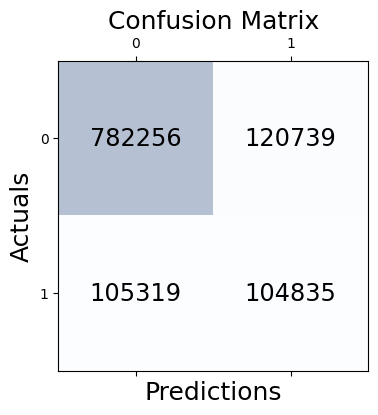

In [11]:
evaluation(y_test, y_pred_logreg_tuned_rosrus, logreg_tuned_rosrus, y_pred_prob_logreg_tuned_rosrus, results)

## Evaluate XGBoost tuned ROS+RUS model

In [8]:
xgb_class_tuned_rosrus = joblib.load(path_model + "XGBoost_tuned_ROSRUS.joblib")
y_pred_xgb_tuned_rosrus = xgb_class_tuned_rosrus.predict(X_test)
y_pred_prob_xgb_tuned_rosrus = xgb_class_tuned_rosrus.predict_proba(X_test)[:, 1]

AUROC Score:  0.819
Accuracy Score:  0.816
Balanced Accuracy Score:  0.746
F1 Score:  0.566
Recall Score:  0.635
Precision Score:  0.51


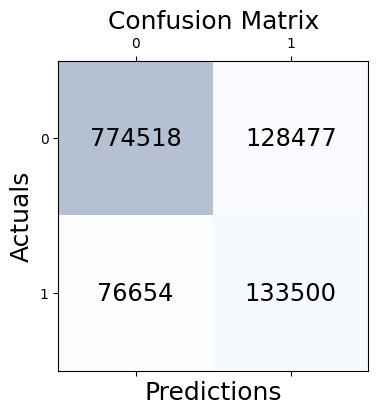

In [9]:
evaluation(y_test, y_pred_xgb_tuned_rosrus, xgb_class_tuned_rosrus, y_pred_prob_xgb_tuned_rosrus, results)

## Evaluate TabNet tuned ROS+RUS model

In [6]:
tabnet_tuned_rosrus = torch.load(path_model + "TabNet_tuned_ROSRUS.pt", map_location=torch.device('cpu'))
tabnet_tuned_rosrus.device = "cpu"
y_pred_tabnet_tuned_rosrus = tabnet_tuned_rosrus.predict(X_test.values)
y_pred_prob_tabnet_tuned_rosrus = tabnet_tuned_rosrus.predict_proba(X_test.values)[:, 1]

AUROC Score:  0.767
Accuracy Score:  0.79
Balanced Accuracy Score:  0.701
F1 Score:  0.501
Recall Score:  0.559
Precision Score:  0.454


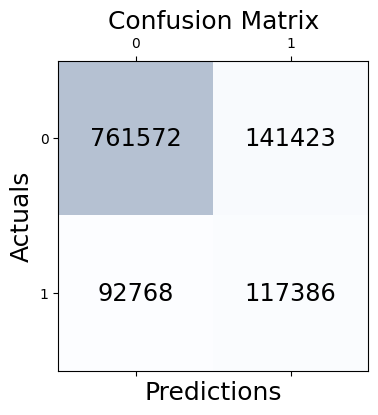

In [7]:
evaluation(y_test, y_pred_tabnet_tuned_rosrus, tabnet_tuned_rosrus, y_pred_prob_tabnet_tuned_rosrus, results)

## Evaluate Random Forests tuned ROS+RUS model

In [3]:
rf_tuned_rosrus = joblib.load(path_model + "rf_tuned_ROSRUS.joblib")
y_pred_rf_tuned_rosrus = rf_tuned_rosrus.predict(X_test)
y_pred_prob_rf_tuned_rosrus = rf_tuned_rosrus.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   44.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   44.4s finished


AUROC Score:  0.798
Accuracy Score:  0.814
Balanced Accuracy Score:  0.726
F1 Score:  0.543
Recall Score:  0.584
Precision Score:  0.506


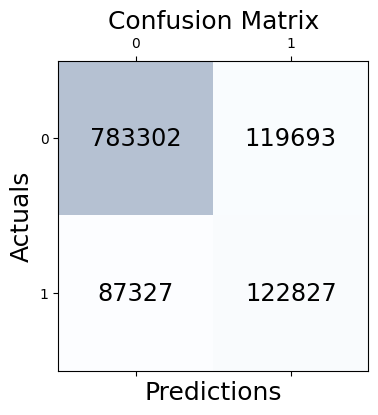

In [4]:
evaluation(y_test, y_pred_rf_tuned_rosrus, rf_tuned_rosrus, y_pred_prob_rf_tuned_rosrus, results)

## Final results per model

In [12]:
results.sort_values(by=["AUROC"], ascending=False)

,Model,AUROC,Accuracy,F1,Recall,Precision
3,XGBClassifier,0.819,0.816,0.566,0.635,0.510
1,RandomForestClassifier,0.798,0.814,0.543,0.584,0.506
2,TabNetClassifier,0.767,0.790,0.501,0.559,0.454
4,LogisticRegression,0.740,0.797,0.481,0.499,0.465


In [ ]:
final_result = model_results.groupby('Model').agg({
    'AUROC': [('mean', 'mean'), ('range', lambda x: np.max(x) - np.min(x))],
    'Accuracy': [('mean', 'mean'), ('range', lambda x: np.max(x) - np.min(x))],
    'F1': [('mean', 'mean'), ('range', lambda x: np.max(x) - np.min(x))],
    'Recall': [('mean', 'mean'), ('range', lambda x: np.max(x) - np.min(x))],
    'Precision': [('mean', 'mean'), ('range', lambda x: np.max(x) - np.min(x))]
})

final_result.columns = ['_'.join(col).strip() for col in final_result.columns.values]

final_result.sort_values(by=["AUROC_mean"], ascending=False)

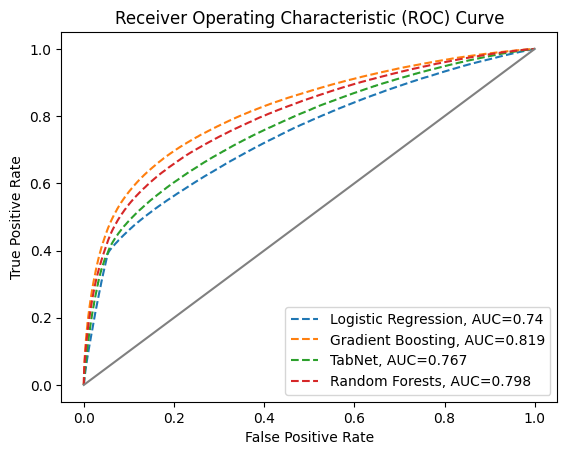

<Figure size 1400x1200 with 0 Axes>

In [13]:
auroc_curve(y_test, y_pred_prob_logreg_tuned_rosrus, y_pred_prob_xgb_tuned_rosrus, y_pred_prob_tabnet_tuned_rosrus, y_pred_prob_rf_tuned_rosrus)

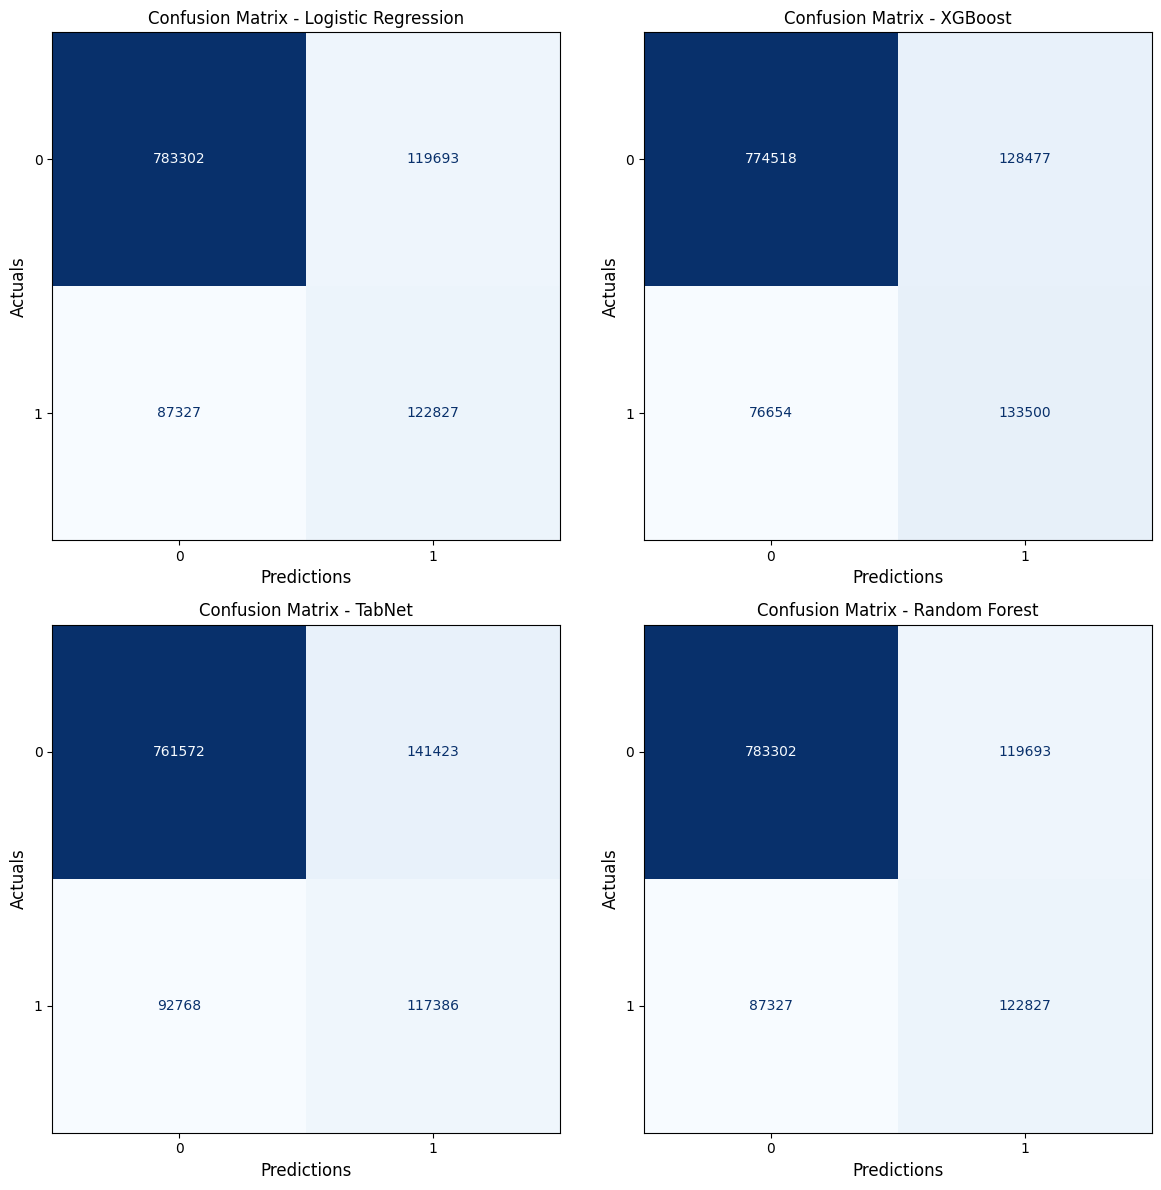

In [14]:
complete_confusion_matrix(y_test, [y_pred_rf_tuned_rosrus, 
                                   y_pred_xgb_tuned_rosrus, 
                                   y_pred_tabnet_tuned_rosrus, 
                                   y_pred_rf_tuned_rosrus], 
                                   ['Logistic Regression', 
                                    'XGBoost', 
                                    'TabNet', 
                                    'Random Forest'])